In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
rhoa = 10

# Set initial positions for ABMN
A = (-1, 0)
M = (-0.5, 0)
N = (0.5, 0)
B = (1, 0)

def schlumberger(A, B, M, N, rhoa):
    ax = A[0]
    ay = A[1]
    
    bx = B[0]
    by = B[1]
    
    mx = M[0]
    my = M[1]
    
    nx = N[0]
    ny = N[1]
    
    k = 2*np.pi/(((ax-mx)**2 + (ay-my)**2)**-0.5 - ((bx-mx)**2 + (by-my)**2)**-0.5 - ((ax-nx)**2 + (ay-ny)**2)**-0.5 + ((bx-nx)**2 + (by-ny)**2)**-0.5)
    
    r = rhoa/k
    
    return r, k

def resistivity(A, B, M, N, r):
    ax = A[0]
    ay = A[1]
    
    bx = B[0]
    by = B[1]
    
    mx = M[0]
    my = M[1]
    
    nx = N[0]
    ny = N[1]
    
    k = 2*np.pi/(((ax-mx)**2 + (ay-my)**2)**-0.5 - ((bx-mx)**2 + (by-my)**2)**-0.5 - ((ax-nx)**2 + (ay-ny)**2)**-0.5 + ((bx-nx)**2 + (by-ny)**2)**-0.5)
    rhoa = r*k
    
    return rhoa, k

In [11]:
import csv

# Let me actually get ABMN positions from Raul's data.
rows = []
with open('cowsjackpot.csv', newline='') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
     for row in spamreader:
         rows.append(', '.join(row))

In [12]:
import io
colnames=["N", "a", "n", "ab2", "r", "rhoa", "sigma"] 
dcowsns = pd.read_csv(io.StringIO('\n'.join(rows[2:14])), names=colnames)
dcowses = pd.read_csv(io.StringIO('\n'.join(rows[18:30])), names=colnames)
mcowsns = pd.read_csv(io.StringIO('\n'.join(rows[34:47])), names=colnames)

djackns = pd.read_csv(io.StringIO('\n'.join(rows[51:64])), names=colnames)
mjackns = pd.read_csv(io.StringIO('\n'.join(rows[68:])), names=colnames)



In [20]:
df2 = dcowsns

n = df2["n"] + 1
a = df2["a"] + 1

# n = np.linspace(0.01, 100, 1000)
# a = np.zeros(n.shape) + 1

mx = -a/2
my =  np.zeros(len(a))
M = np.array([mx, my])

nx = a/2
ny =  np.zeros(len(a))
N = np.array([nx, ny])

ax = -(n+1/2)*a
ay =  np.zeros(len(a))
A = np.array([ax, ay])

bx = (n+1/2)*a
by = np.zeros(len(a))
B = np.array([bx, by])

In [21]:
# Now looking at the schlumberger response.
r, k = schlumberger(A, B, M, N, rhoa)
check_rhoa, k = resistivity(A, B, M, N, r)
ab2 = bx

Text(0, 0.5, 'AB/2 (m)')

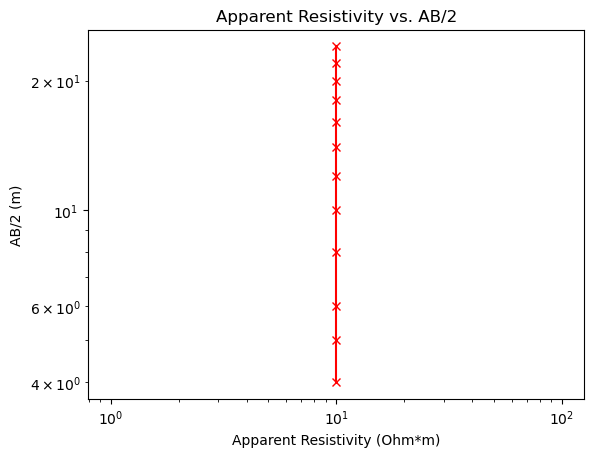

In [22]:
# Graphing.
plt.loglog(np.array(check_rhoa).reshape(len(check_rhoa),1), np.array(ab2).reshape(len(ab2),1), 'rx-', label='measured')
plt.title("Apparent Resistivity vs. AB/2")
plt.xlabel("Apparent Resistivity (Ohm*m)")
plt.ylabel("AB/2 (m)")

/var/folders/_7/x_mxrhfx0gq6pt61nr_x9t880000gn/T/ipykernel_9213/2547292010.py:41: RuntimeWarning: divide by zero encountered in power
  k = 2*np.pi/(((ax-mx)**2 + (ay-my)**2)**-0.5 - ((bx-mx)**2 + (by-my)**2)**-0.5 - ((ax-nx)**2 + (ay-ny)**2)**-0.5 + ((bx-nx)**2 + (by-ny)**2)**-0.5)


(11.0, 1.0)

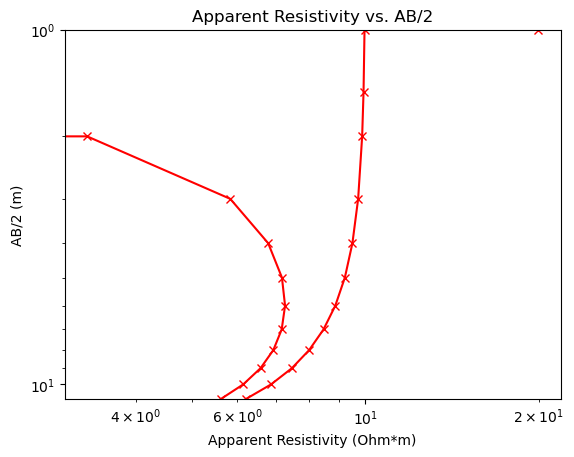

In [16]:
# Now adding a lead resistiance in parallel.

cres = -0.01 # 50 ohms lead resistance
r#cres = (1/r + 1/cres)**-1

rcres = r + cres

# Looking at resistivity for this.
cres_rhoa, k = resistivity(A, B, M, N, rcres)
ANEW = np.array([A[0]+1, A[1]])
anew_rhoa, k = resistivity(ANEW, B, M, N, rcres)

# Plotting.
plt.loglog(np.array(cres_rhoa).reshape(len(cres_rhoa),1), np.array(ab2).reshape(len(ab2),1), 'rx-', label='measured')
plt.title("Apparent Resistivity vs. AB/2")
plt.xlabel("Apparent Resistivity (Ohm*m)")
plt.ylabel("AB/2 (m)")
plt.ylim(max(ab2), min(ab2))

plt.loglog(np.array(anew_rhoa).reshape(len(anew_rhoa),1), np.array(ab2).reshape(len(ab2),1), 'rx-', label='measured')
plt.title("Apparent Resistivity vs. AB/2")
plt.xlabel("Apparent Resistivity (Ohm*m)")
plt.ylabel("AB/2 (m)")
plt.ylim(max(ab2), min(ab2))

Text(0, 0.5, 'AB/2 (m)')

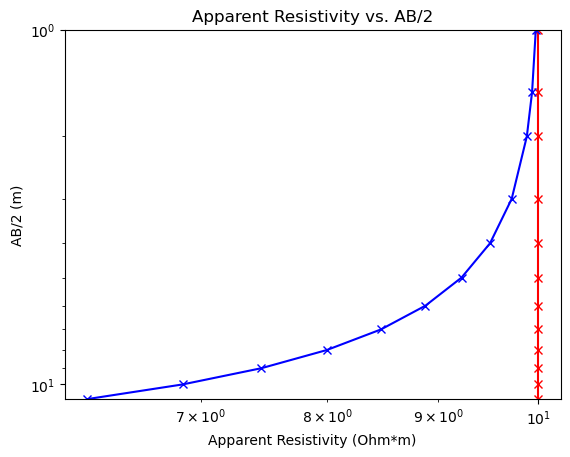

In [11]:
# Bingo! Plotting both on top of each other for dramatic effect.

plt.loglog(np.array(check_rhoa).reshape(len(check_rhoa),1), np.array(ab2).reshape(len(ab2),1), 'rx-', label='measured')
plt.loglog(np.array(cres_rhoa).reshape(len(cres_rhoa),1), np.array(ab2).reshape(len(ab2),1), 'bx-', label='measured')
plt.ylim(max(ab2), min(ab2))
plt.title("Apparent Resistivity vs. AB/2")
plt.xlabel("Apparent Resistivity (Ohm*m)")
plt.ylabel("AB/2 (m)")

In [12]:
# Now looking at a two-layer model.
rhoa1 = 100
thk1 = 1

rhoa2 = 500
thk2 = np.inf

def rhoa_layers(rhoa, thk, z):
    # Find the average rhoa across an equipotential shell as a function of depth
    # I'm assuming a spherical shell with radius z for now. This isn't true as shown in 
    # WIP Ohmpi Theory document, but it is quick to calculate for me.
    
    # Area of shell covered by layer1:
    
    a1 = 1
    

In [13]:
k

array([  2.35619449,   6.28318531,  11.78097245,  27.48893572,
        49.48008429,  77.75441818, 112.31193737, 153.15264186,
       200.27653167, 253.68360678, 313.3738672 , 379.34731292])

I want to see if I can fit one of the datasets for a resistance added in series.
I'm going to use scipy's curve_fit using n as the independent variable, apparent 
resistivity as the dependent variable, and the lead resistance an soil resistance as 
fitting parameters. I'm going to use one the datsets where I'm pretty sure that the soil fit best
with one layer accoridng to my initial fits and ian's results.

0     10.22
1      3.99
2      2.05
3      0.77
4      0.35
5      0.19
6      0.12
7      0.07
8      0.05
9      0.03
10     0.02
11     0.01
12     0.01
Name: r, dtype: float64

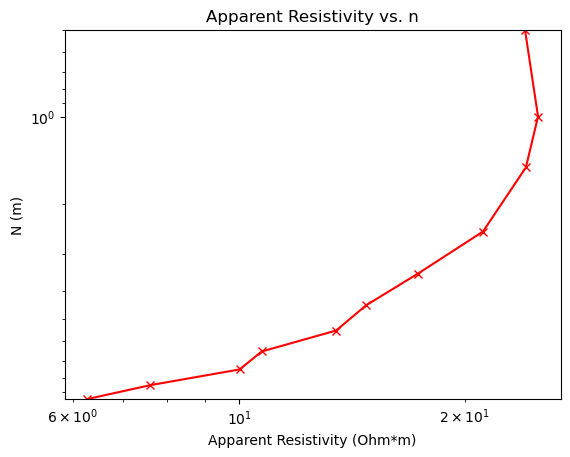

In [27]:
# Jackpot looks like it has one layer. I'm going to use the monopole north-south data.
df2 = mjackns

x = df2["n"][:-2]
y = df2["rhoa"][:-2]

plt.loglog(np.array(y).reshape(len(y),1), np.array(x).reshape(len(x),1), 'rx-', label='measured')
plt.ylim(max(x), min(x))
plt.title("Apparent Resistivity vs. n")
plt.xlabel("Apparent Resistivity (Ohm*m)")
plt.ylabel("N (m)")

In [130]:
from scipy.optimize import curve_fit

def rhoafit(n, rhoa, rlead):
    a = 1
    mx = -a/2
    my =  np.zeros(len(n))
    M = np.array([mx, my], dtype=object)

    nx = a/2
    ny =  np.zeros(len(n))
    N = np.array([nx, ny], dtype=object)

    ax = -(n+1/2)*a
    ay =  np.zeros(len(n))
    A = np.array([ax, ay], dtype=object)

    bx = (n+1/2)*a
    by = np.zeros(len(n))
    B = np.array([bx, by], dtype=object)
    
    k = 2*np.pi/(((ax-mx)**2 + (ay-my)**2)**-0.5 - ((bx-mx)**2 + (by-my)**2)**-0.5 - ((ax-nx)**2 + (ay-ny)**2)**-0.5 + ((bx-nx)**2 + (by-ny)**2)**-0.5)  
    return rhoa + (rlead)*k

rhoafit(df2["r"][:-3], 1, 1)

r = df2["r"][:-3]
rhoa = df2["rhoa"][:-3]
n, rhoa

(0    0.5
 1    1.0
 2    1.5
 3    2.5
 4    3.5
 5    4.5
 6    5.5
 7    6.5
 8    7.5
 9    8.5
 Name: n, dtype: float64,
 0    24.080308
 1    25.069909
 2    24.150994
 3    21.166480
 4    17.318030
 5    14.773339
 6    13.477432
 7    10.720685
 8    10.013827
 9     7.610508
 Name: rhoa, dtype: float64)

In [131]:
n = df2["n"][:-3]
popt, pcov = curve_fit(rhoafit, n, rhoa)
popt

array([23.08582574, -0.06984009])

Text(0, 0.5, 'N (m)')

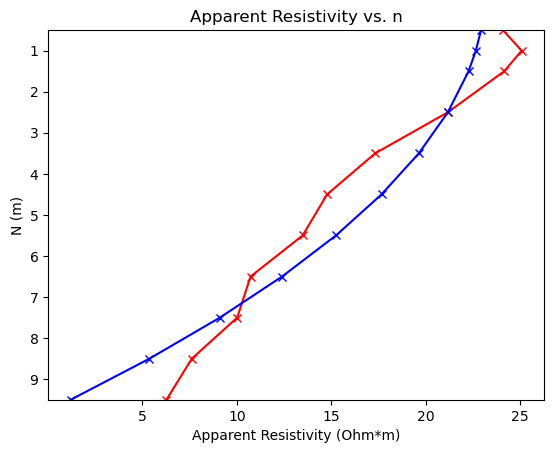

In [132]:
df2 = mjackns

x = df2["n"][:-2]
y = df2["rhoa"][:-2]

plt.plot(np.array(y).reshape(len(y),1), np.array(x).reshape(len(x),1), 'rx-', label='measured')
plt.plot(rhoafit(x, *popt), x, 'bx-', label='measured')
plt.ylim(max(x), min(x))
plt.title("Apparent Resistivity vs. n")
plt.xlabel("Apparent Resistivity (Ohm*m)")
plt.ylabel("N (m)")

In [142]:
# Wow this is a really bad fit. I'm moving forward with the correction anyways in the interest of time.
# Ig the goal is to just show that the lead resistance can account for something??
import pickle

with open(f"pickled_fit", 'wb') as file:
    pickle.dump(popt, file=file)

# correct for lead resistance
rnew = r - popt[1]

Text(0, 0.5, 'N (m)')

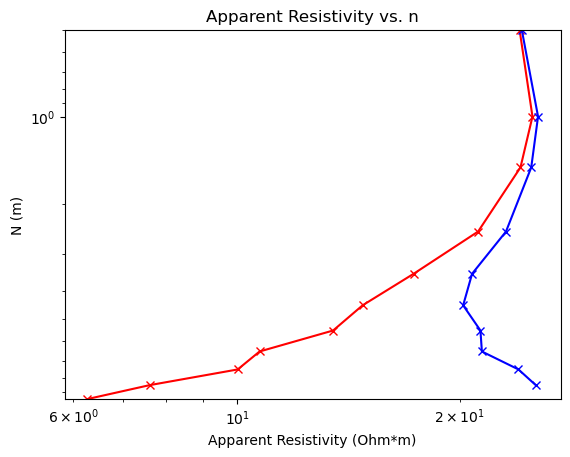

In [150]:
df2 = mjackns

x = df2["n"][:-2]
y = df2["rhoa"][:-2]

plt.loglog(np.array(y).reshape(len(y),1), np.array(x).reshape(len(x),1), 'rx-', label='measured')
plt.loglog(rnew*k[:-2], x[:-1], 'bx-', label='measured')
plt.ylim(max(x), min(x))
plt.title("Apparent Resistivity vs. n")
plt.xlabel("Apparent Resistivity (Ohm*m)")
plt.ylabel("N (m)")

In [120]:
rhoafit(x, *popt)

0     22.921269
1     22.647008
2     22.263042
3     21.165996
4     19.630132
5     17.655450
6     15.241950
7     12.389631
8      9.098495
9      5.368540
10     1.199767
Name: n, dtype: float64